In [1]:
import json
import os
from pathlib import Path
import metapy
import csv
# wget -nc https://raw.githubusercontent.com/meta-toolkit/meta/master/data/lemur-stopwords.txt
import pandas as pd
from gensim import corpora
import gensim
import matplotlib.pyplot as plt
import random
import numpy as np
random.seed(123)

Functions used for topic mining are similar to ones in mine_lecture_transcripts.py
Code at end does the model exploration.

In [2]:
def preprocess_text(doc):
    """ 
    Write token stream that:
    - tokenizes with ICUTokenizer, 
    - lowercases, 
    - removes words with less than 2 and more than 30  characters, and stop words
    - performs stemming and creates unigrams 
    
    """
    
    tok = metapy.analyzers.ICUTokenizer(suppress_tags=True)
    tok = metapy.analyzers.LowercaseFilter(tok)
    tok = metapy.analyzers.LengthFilter(tok, min=2, max=30)
    tok = metapy.analyzers.Porter2Filter(tok)
    tok = metapy.analyzers.ListFilter(tok, "lemur-stopwords.txt", metapy.analyzers.ListFilter.Type.Reject)
    ana = metapy.analyzers.NGramWordAnalyzer(1, tok)

    processedtxt = ana.analyze(doc)
    
    tok.set_content(doc.content())
    tokens, counts = [], []
    for token, count in processedtxt.items():
        counts.append(count)
        tokens.append(token)
    return tokens, counts

In [3]:
def get_transcripts(filenames):
    
    """
    Load and combine transcripts in json format into one dictionary, with keys as lecture titles and values as transcript text.
    """
    
    all_lesson_titles = list()
    all_transcripts = {}
    for filename in filenames:
        
        with open(filename, 'r') as f:
            transcripts = json.load(f)
        
        all_transcripts.update(transcripts)
        
        lesson_titles = list(transcripts.keys())
        all_lesson_titles = all_lesson_titles + lesson_titles
 
    return all_transcripts, all_lesson_titles

In [4]:
def get_tokens(transcripts, lesson_titles):
    
    """
    Pre-process each document into list of tokens (calling preprocess_text()).
    """
    
    lecture_tokens = {}
    lecture_token_counts = {}
    lecture_tokens_list = []
    for title in lesson_titles: #  ['01_course-welcome-video.en.txt']

        doctxt = transcripts[title]

        doc = metapy.index.Document()
        doc.content(doctxt)

        tokens,counts = preprocess_text(doc)
        lecture_tokens[title] = tokens
        lecture_token_counts[title] = counts
        lecture_tokens_list.append(tokens)
    return lecture_tokens, lecture_tokens_list, lecture_token_counts

In [5]:
def output_tokens_tocsv(lecture_tokens, output_filename):
    
    with open(output_filename, 'w') as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in lecture_tokens.items():
           writer.writerow([key, value])
    

In [6]:
def create_lda_model(lecture_tokens_list, ntopics, niterations):
    """
    Transform tokens data to BoW with Tf-IDF weighting to consider rare terms more while reducing weight on common words (important especially for verbal text).
    Create LDA model with given parameters found through model grid search and experimentation.
    Code adapted from: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
                       https://highdemandskills.com/topic-modeling-lda/
    """
    np.random.seed(12345)
    dictionary = corpora.Dictionary(lecture_tokens_list)
    corpus = [dictionary.doc2bow(text) for text in lecture_tokens_list]

    TFIDF = gensim.models.TfidfModel(corpus) 
    trans_TFIDF = TFIDF[corpus] 

    best_model = gensim.models.ldamodel.LdaModel(trans_TFIDF, 
                                                   num_topics = ntopics, 
                                                   id2word=dictionary,
                                                   iterations = niterations
                                                  )
    return best_model, corpus

In [20]:
def find_best_model_gridsearch(lecture_tokens_list, start,stop,step):
    """
    Perform grid search through number of topics to find optimal model in terms of topic coherence values.
    Visualize plot on parameters and their performance.
    Get best model with highest performance.
    
    """
    dictionary = corpora.Dictionary(lecture_tokens_list)
    corpus = [dictionary.doc2bow(text) for text in lecture_tokens_list]

    TFIDF = gensim.models.TfidfModel(corpus)
    trans_TFIDF = TFIDF[corpus] 


    coherence_values = []
    candidate_models = []

    for n_topics in range(start, stop, step):
            ldamodel = gensim.models.ldamodel.LdaModel(trans_TFIDF, 
                                                       num_topics = n_topics, 
                                                       id2word=dictionary,
                                                       iterations = 200
                                                      )
            coherence_model_lda = gensim.models.CoherenceModel(model=ldamodel, texts=lecture_tokens_list, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherence_model_lda.get_coherence())
            candidate_models.append((n_topics, ldamodel))

    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    # get best topic model
    best_model_coherence = max(coherence_values)
    best_model_index = coherence_values.index(max(coherence_values))
    best_model_ntopics, best_model = candidate_models[best_model_index]
    print('# topics: ', best_model_ntopics, best_model_coherence)
    return best_model,corpus



In [8]:
def get_doc_summary(model, lecture_tokens_list, corpus,lesson_titles): 
    """
    Get the most dominant topic for each doc, and their topic coverage, top keywords in dominant topic.
    Adapted from arxiv/topic_modeler.py
    """
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(model[corpus]):
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([lesson_titles[i],int(topic_num), round(prop_topic, 4), row, topic_keywords]), ignore_index=True)
                else:
                    break
    sent_topics_df.columns = ['Lecture_Title','Dominant_Topic', 'Dominant_Topic_Perc_Contribution','Topic Coverage', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(lecture_tokens_list)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    doc_topic_summary = sent_topics_df.reset_index()
    doc_topic_summary.columns = ['Document_No','Lecture_Title', 'Dominant_Topic', 'Dominant_Topic_Perc_Contribution','Topic Coverage', 'Keywords', 'Text']

    return sent_topics_df, doc_topic_summary


In [9]:
def produce_topic_summary_df(sent_topics_df): 
    """
    Produce topic distribution across documents to assess topic selection quality.
    Adapted from arxiv/topic_modeler.py
    """
        
    topic_summary = sent_topics_df.groupby(['Dominant_Topic', 'Topic_Keywords']).agg('count').reset_index().sort_values('Dominant_Topic_Perc_Contribution', ascending=False)
    topic_summary = topic_summary.iloc[: , :-3]
    topic_summary.columns = ['Dominant_Topic', 'Topic_Keywords','Num_Documents']
    topic_summary['Perc_Documents'] = topic_summary.Num_Documents/topic_summary.Num_Documents.sum()
    topic_summary

    return topic_summary

## Visualizing the grid search across number of topics

Conduct grid search to determine number of topics and iterations

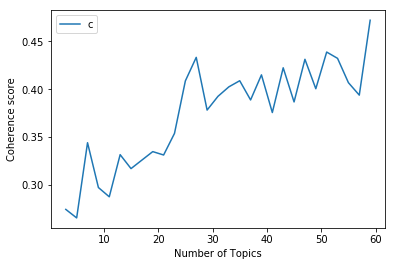

# topics:  59 0.4719050508007679


,Document_No,Lecture_Title,Dominant_Topic,Dominant_Topic_Perc_Contribution,Topic Coverage,Keywords,Text
0,0,03_1-3-natural-language-content-analysis-part-...,58.0,0.2539,"[(58, 0.25387383), (49, 0.22239761), (0, 0.168...","anyth, attach, underflow, bar, trsa, 0.6, piz,...","[help, human, special, tree, categori, domain,..."
1,1,06_2-6-topic-mining-and-analysis-term-as-topic...,49.0,0.3018,"[(49, 0.30182192), (57, 0.2429813), (0, 0.1942...","i'll, trigger, smooth, appear, rememb, ignor, ...","[threshold, special, deal, gradual, domain, ra..."
2,2,03_4-3-text-clustering-generative-probabilisti...,49.0,0.4106,"[(49, 0.4105815), (4, 0.22678992), (0, 0.19411...","i'll, trigger, smooth, appear, rememb, ignor, ...","[help, precis, infer, import, posterior, conte..."
3,3,02_course-prerequisites-completion.en.txt,31.0,0.4667,"[(31, 0.4666959), (0, 0.18091366), (49, 0.1704...","navig, whenev, titl, co, protect, emphasis, su...","[help, human, import, option, anoth, domain, s..."
4,4,03_2-3-syntagmatic-relation-discovery-mutual-i...,0.0,0.2601,"[(0, 0.26011124), (49, 0.2526347), (58, 0.1015...","judgement, cutoff, rang, util, built, divid, b...","[help, anoth, wherea, take, talk, becaus, mine..."
5,5,02_4-2-text-clustering-generative-probabilisti...,49.0,0.3173,"[(49, 0.31726587), (0, 0.20300514), (14, 0.113...","i'll, trigger, smooth, appear, rememb, ignor, ...","[regener, wherea, take, decid, becaus, mine, r..."
6,6,06_5-6-opinion-mining-and-sentiment-analysis-s...,49.0,0.2359,"[(49, 0.23593998), (0, 0.22260714), (47, 0.214...","i'll, trigger, smooth, appear, rememb, ignor, ...","[mayb, help, human, element, tree, otherwis, d..."
7,7,05_3-5-probabilistic-topic-models-expectation-...,49.0,0.2488,"[(49, 0.24878676), (0, 0.20509507), (36, 0.193...","i'll, trigger, smooth, appear, rememb, ignor, ...","[help, audit, gradual, anoth, column, full, ta..."
8,8,07_3-7-probabilistic-latent-semantic-analysis-...,49.0,0.2711,"[(49, 0.27107394), (0, 0.2562867), (19, 0.2107...","i'll, trigger, smooth, appear, rememb, ignor, ...","[help, categori, line, constrain, take, closer..."
9,9,01_introduction-to-text-mining-and-analytics.e...,52.0,0.4813,"[(52, 0.48127514), (49, 0.15056159), (0, 0.143...","crucial, w_i, reserv, skill, net, familiar, em...","[help, special, web, pipelin, small, trend, ta..."


In [22]:
np.random.seed(12345)
filenames = ['transcripts_text-mining_txt.json','transcripts_text-retrieval_txt.json']
transcripts, lesson_titles = get_transcripts(filenames)
lecture_tokens, lecture_tokens_list, lecture_token_counts = get_tokens(transcripts, lesson_titles)    

model,corpus = find_best_model_gridsearch(lecture_tokens_list, start = 3, stop = 60,step=2)  
# model,corpus = create_lda_model(lecture_tokens_list, ntopics = 41, niterations = 200)
sent_topics_df, doc_topic_summary = get_doc_summary(model, lecture_tokens_list, corpus,lesson_titles)

topic_summary = produce_topic_summary_df(sent_topics_df)
    

doc_topic_summary    

Although more topics leads to higher coherence scores, when we look at the actual topic content, most documents will be assigned to < 5 clusters, with the rest of the clusters with 1 or 0 documents.
This is common for small datasets (for lecture transcripts, we only have 100 documents).
So we intentionally pick smaller number of clusters to achieve better topic distributions 


In [23]:
topic_summary

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
21,49.0,"i'll, trigger, smooth, appear, rememb, ignor, ...",42,0.42
0,0.0,"judgement, cutoff, rang, util, built, divid, b...",19,0.19
22,52.0,"crucial, w_i, reserv, skill, net, familiar, em...",4,0.04
12,29.0,"decreas, blue, pure, low, come, handbook, ass,...",4,0.04
2,2.0,"award, concis, track, accumul, conserv, loss, ...",4,0.04
8,14.0,"rewrit, pretend, jelinek, pseudocount, placeme...",3,0.03
13,31.0,"navig, whenev, titl, co, protect, emphasis, su...",3,0.03
3,3.0,"mood, they'll, landscap, revert, guidanc, symb...",2,0.02
20,48.0,"confid, left1, window8, immedi, plausibl, pard...",2,0.02
15,37.0,"vers, highway, fan, appoint, assault, reinforc...",2,0.02


Let's deep dive further into the topic contents using pyLDAvis

In [ ]:
# visualize the LDA topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.show(lda_display)



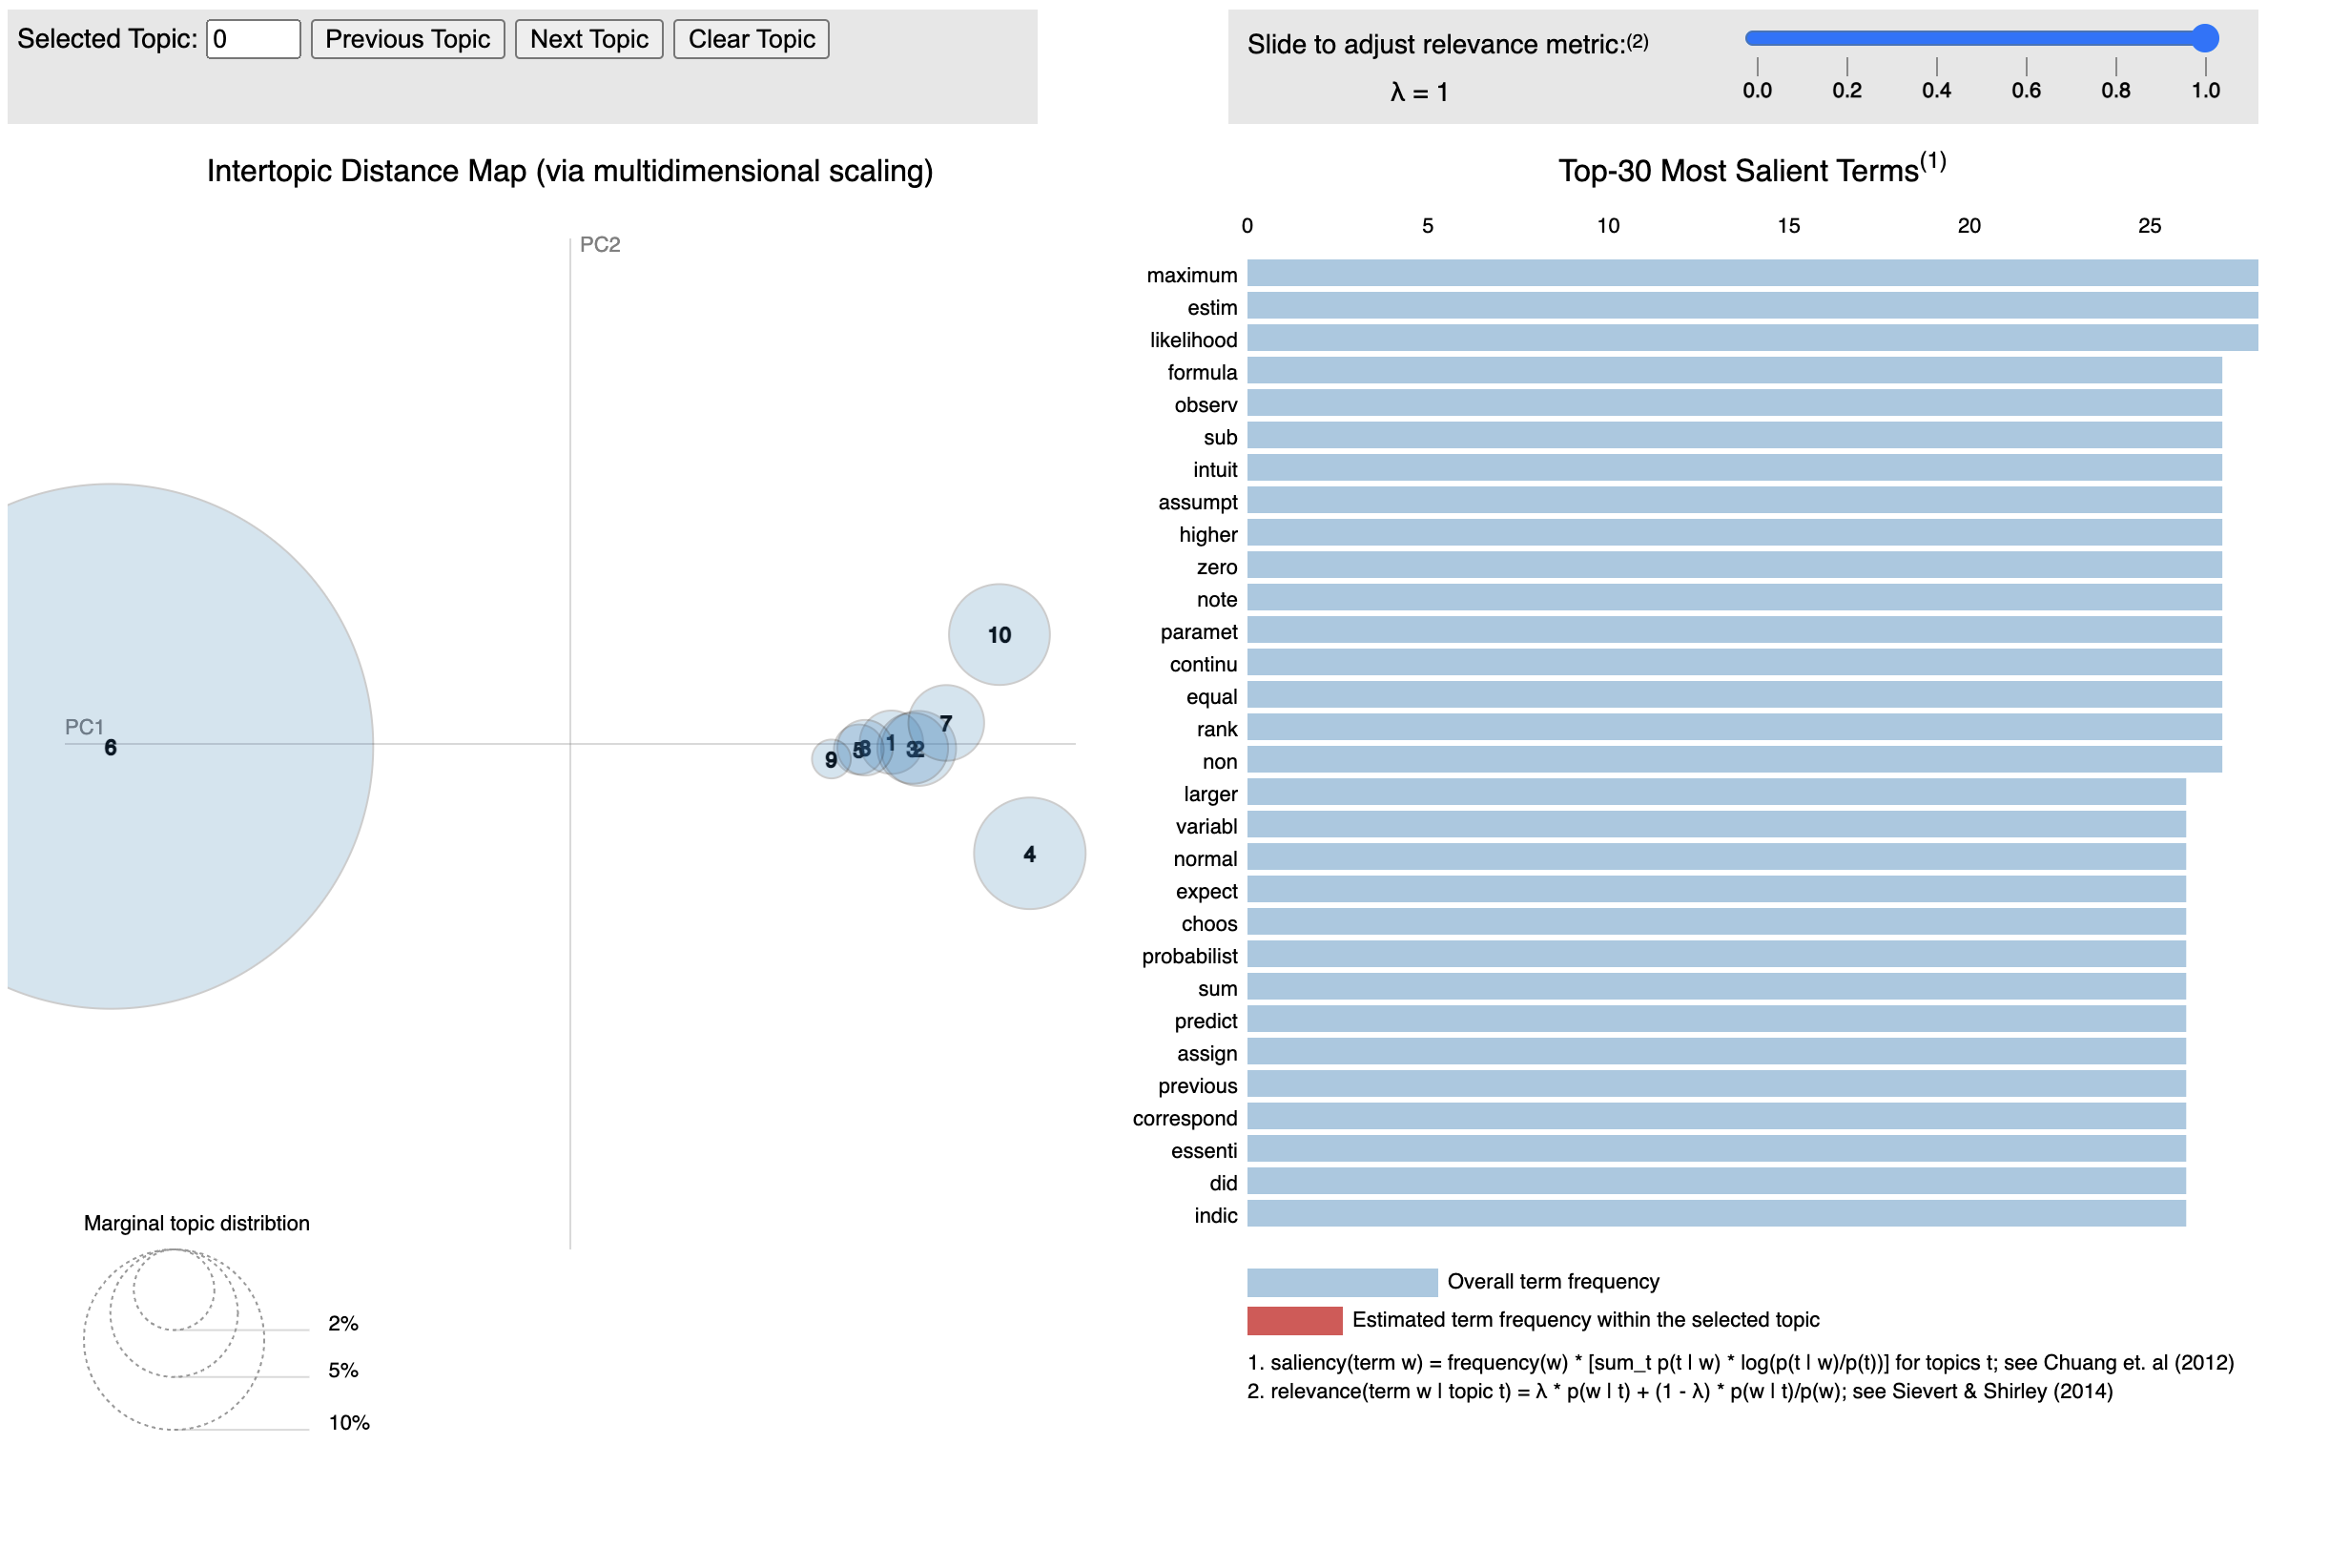

In [25]:
# displaying output from above pyLDAvis
from IPython.display import Image
Image(filename='output2.png') 

When we don't apply TF-IDF, we get common words that are not discriminative as the most salient terms

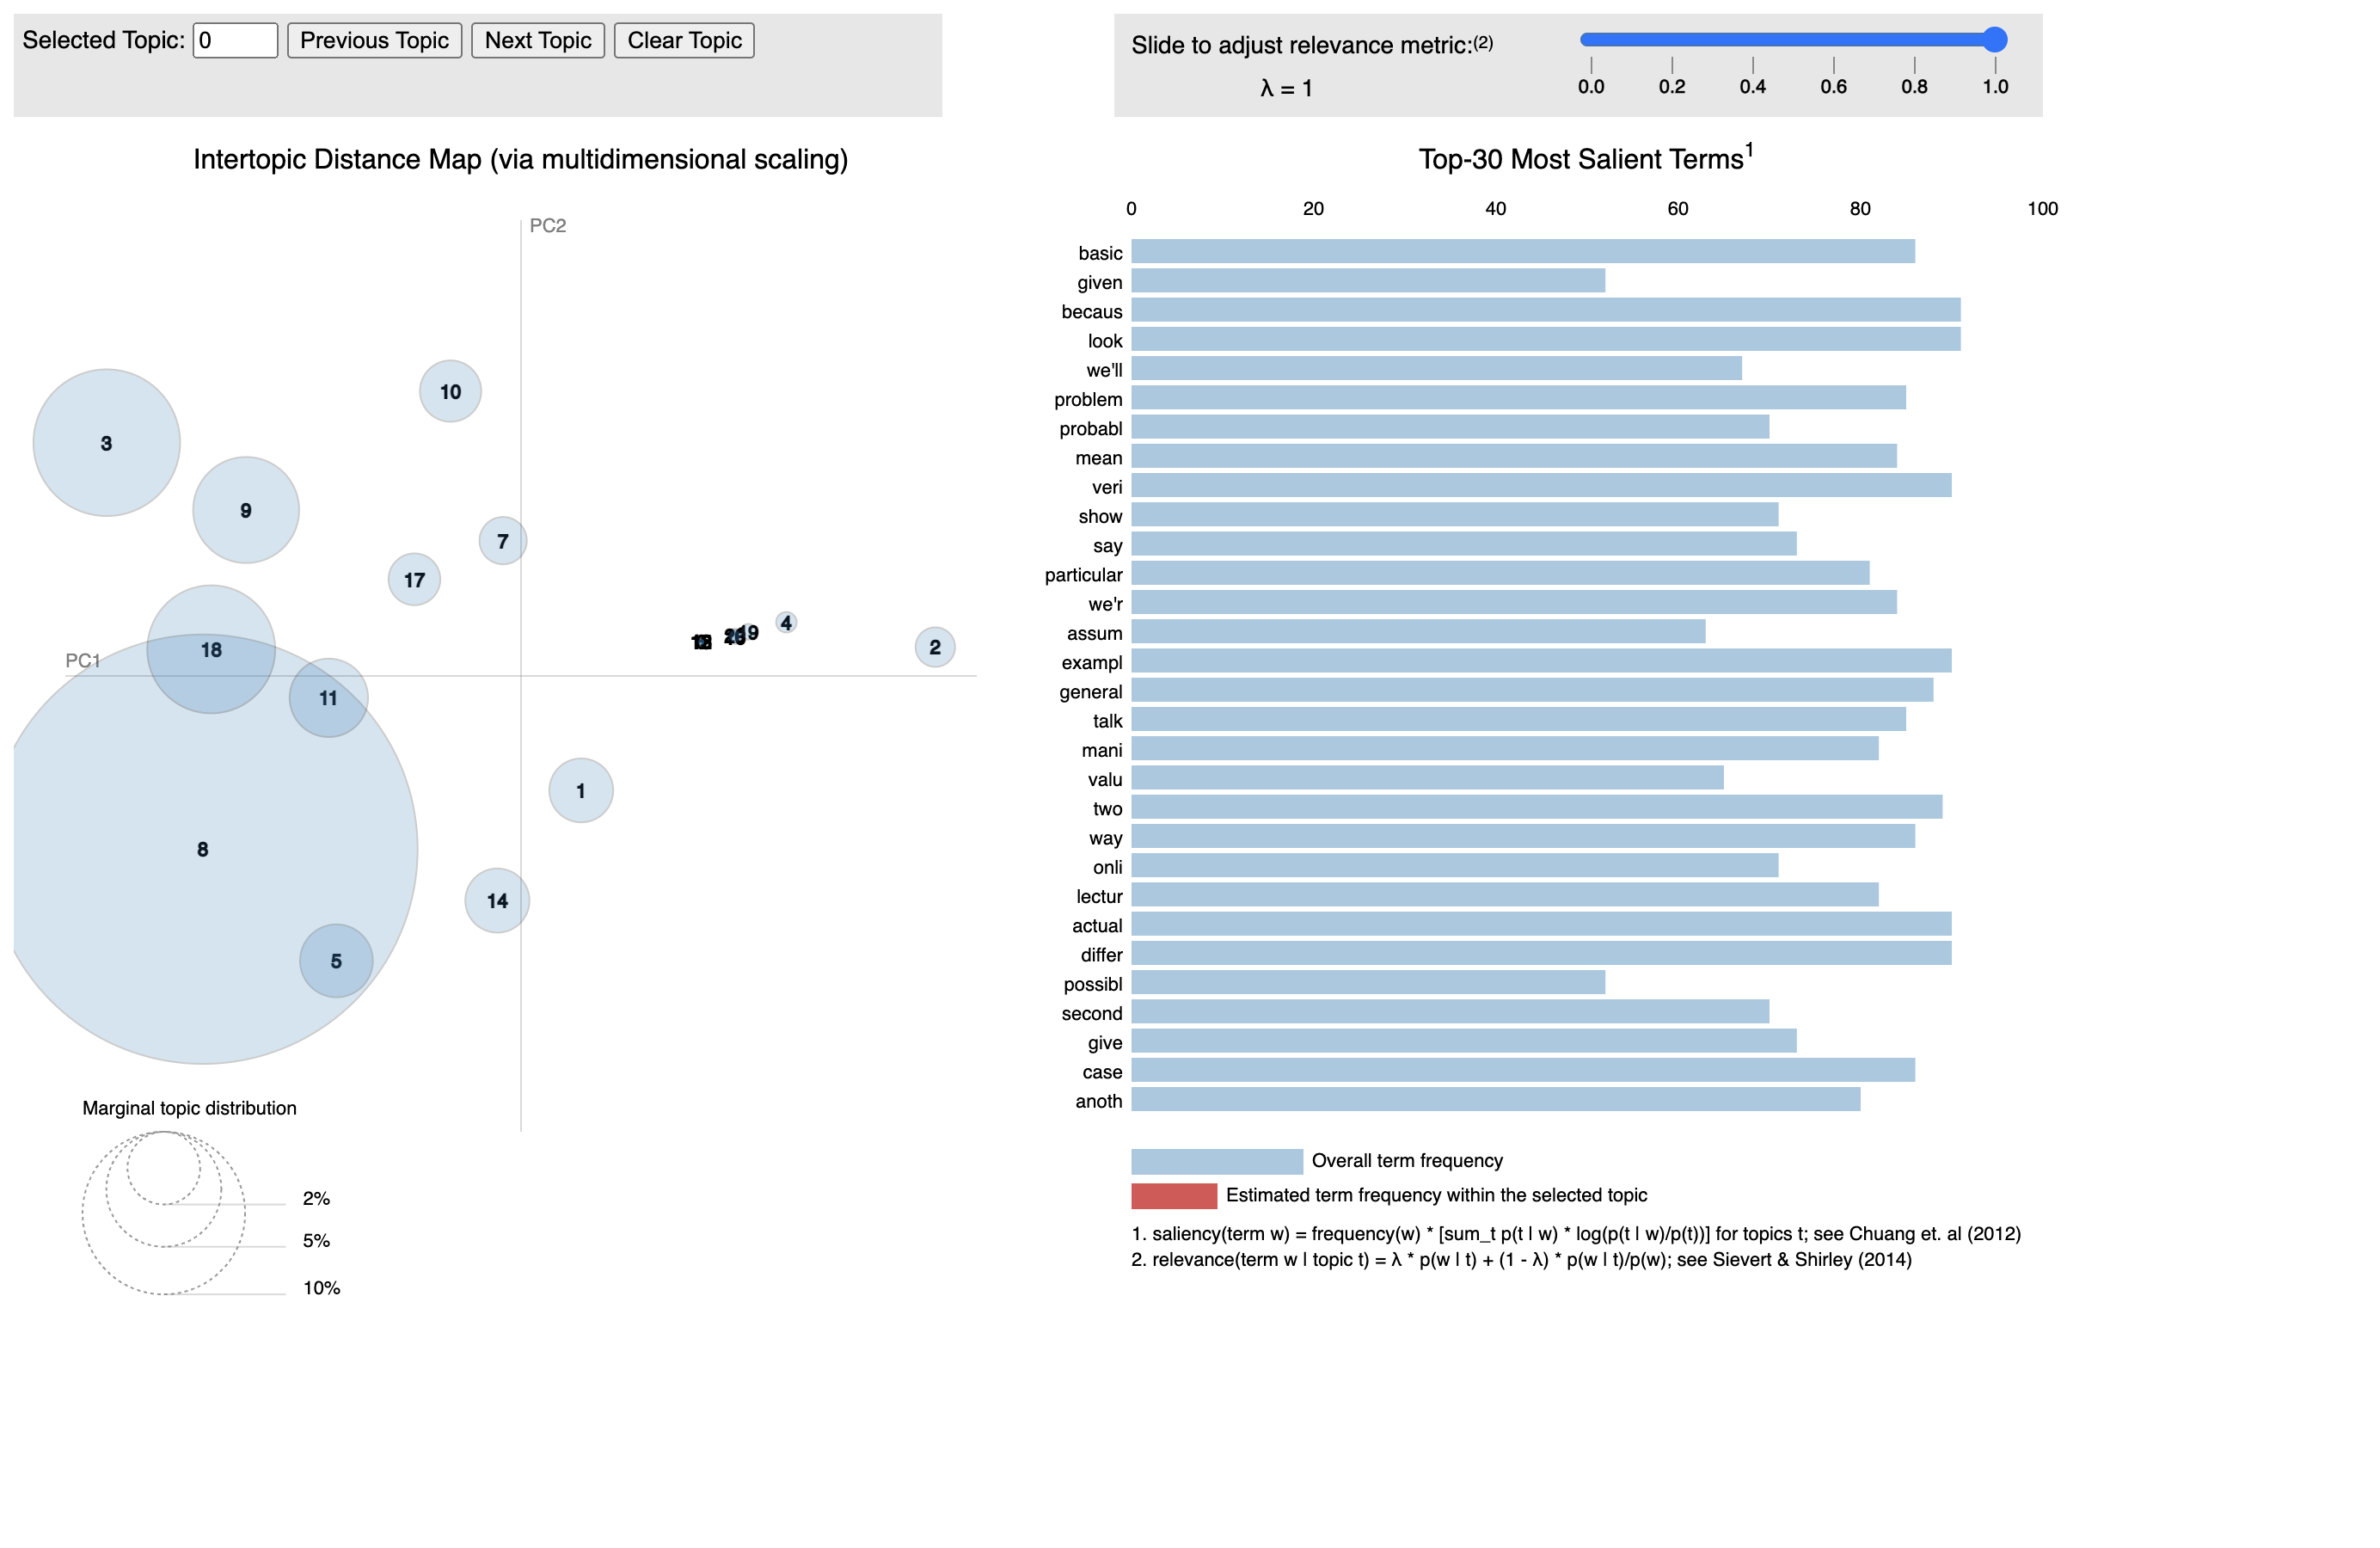

In [24]:
# displaying output from above pyLDAvis
Image(filename='display1.png') 